### Akash Chaurasia
### akashc@jhu.edu
# Classification of cardiomyocites based on their action potentials
In this note we will be looking at the problem of classifying cardiac cells by looking at
their _Action Potentials_ (APs). For the purpose of this task we will be using synthetically
generated APs following the models in [(Nygren et. al, 1998)](https://www.ahajournals.org/doi/abs/10.1161/01.res.82.1.63) and [(O'Hara et. al, 2011)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002061).

### Objectives
Using linear classifiers and nearest-neighbor classifiers for two-class classification problems on features extracted from the training data.

* _Everything below this line is part of my lab report._


In [1]:
# Akash Chaurasia
# akashc@jhu.edu

# ============================================================================
# import modules
# ============================================================================
# Note that this part of the code needs to be run prior to any other code cell
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import random as rnd
from sklearn.decomposition import PCA

# inline plots
%matplotlib inline

# set random number generator seed
rnd.seed(10)

# ============================================================================
# data loading
# ============================================================================

# data path
datapath = '.'

# get the list of files to process
matfile = '/'.join((datapath,'Adult_samples.mat'))

# get data as dictionary (use adata.keys() to see its keys)
adata = scipy.io.loadmat(matfile)


### Task 1. Pre-processing and feature extraction
Normalizing the data and extracting hand-crafted features that will be used for the classification task. Loading the given dataset **Adult_samples.mat** that contains examples of
adult atrial and ventricular action potentials generated using the models in [(Nygren et al., 1998)](https://www.ahajournals.org/doi/abs/10.1161/01.res.82.1.63) and [(O'Hara et al., 2011)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002061).
For each of the two classes there are $1000$ samples generated with a sampling rate of $f_s=500$ Hz.

Spliting the data between test and training sets by
randomly selecting $10\%$ of the points as the training set, making sure the two classes are well represented
in the training set (using 100 for each). For ventricular type I'm using the class label $+1$ and $-1$ for
atrial type. Normalizing the data so that each AP has zero resting potential and unit maximum amplitude.
Plotting data before/after normalization

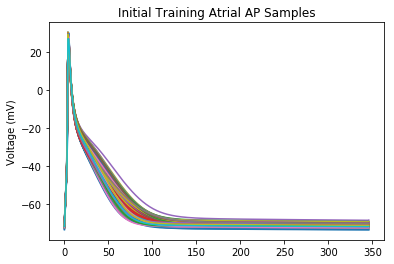

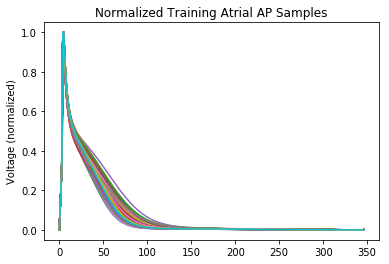

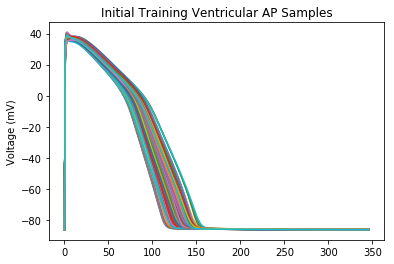

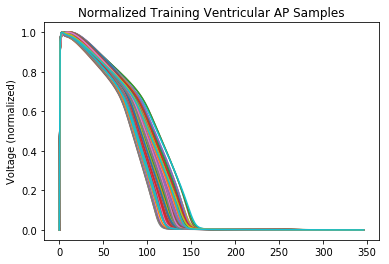

In [2]:
# Extracting the data from the given form

atrial_data = adata['Vatrial']
vent_data = adata['Vventricular']

# Create list of random indices used to get training data points
a_random_indices = []
v_random_indices = []

# Create lists for training data points
atrial_training_data = []
vent_training_data = []

og_atrial_data = []
og_vent_data = []

all_test_data = []
og_test_data = []

# Loop through and get random index that has not yet been used, take that AP
# And add it to our list of training data
for i in range(0, int(atrial_data.shape[1] / 10)):
    r_index = rnd.randrange(atrial_data.shape[0])
    while r_index in a_random_indices:
        r_index = rnd.randrange(atrial_data.shape[0])
    a_random_indices.append(r_index)
    atrial_training_data.append(atrial_data[:, r_index])
    og_atrial_data.append(atrial_data[:, r_index])
               
for i in range(0, int(vent_data.shape[1] / 10)):
    r_index = rnd.randrange(vent_data.shape[0])
    while r_index in v_random_indices:
        r_index = rnd.randrange(vent_data.shape[0])
    v_random_indices.append(r_index)
    vent_training_data.append(vent_data[:, r_index])
    og_vent_data.append(vent_data[:, r_index])

# Add all test data in sequence atrial, ventricular
for i in range(atrial_data.shape[1]):
    if i in a_random_indices:
        continue
    all_test_data.append(atrial_data[:, i])
    og_test_data.append(atrial_data[:, i])
    
for i in range(vent_data.shape[1]):
    if i in v_random_indices:
        continue
    all_test_data.append(vent_data[:, i])
    og_test_data.append(vent_data[:, i])


# Plot before normalization
plt.figure()
plt.plot(np.transpose(atrial_training_data))
plt.title('Initial Training Atrial AP Samples')
plt.ylabel('Voltage (mV)')

# Normalize training data
for i in range(len(atrial_training_data)):
    ap_min = min(og_atrial_data[i])
    atrial_training_data[i] -= ap_min
    ap_max = max(atrial_training_data[i])
    atrial_training_data[i] /= ap_max

# Plot normalized data
plt.figure()
plt.plot(np.transpose(atrial_training_data))
plt.title('Normalized Training Atrial AP Samples')
plt.ylabel('Voltage (normalized)')

# Normalize ventricular data and plot
plt.figure()
plt.plot(np.transpose(vent_training_data))
plt.title('Initial Training Ventricular AP Samples')
plt.ylabel('Voltage (mV)')

for i in range(len(vent_training_data)):
    ap_min = min(vent_training_data[i])
    vent_training_data[i] -= ap_min
    ap_max = max(vent_training_data[i])
    vent_training_data[i] /= ap_max
  
plt.figure()
plt.plot(np.transpose(vent_training_data))
plt.title('Normalized Training Ventricular AP Samples')
plt.ylabel('Voltage (normalized)')

# Normalize test data
for i in range(len(all_test_data)):
    ap_min = min(all_test_data[i])
    all_test_data[i] -= ap_min
    ap_max = max(all_test_data[i])
    all_test_data[i] /= ap_max

The _Action Potential Duration_ (APD) at $x\%$ is defined as the time
it takes to reduce the maximum amplitude of the AP to $x\%$. Makng a function that computes APD at a given
percentage $x\in[0,1]$. Also computing the _Average of the Action Potential_ (AAP) and building two-dimensional features
by concatenating APD@$0.5$ and AAP. Creating a scatter plot of the training data using these two features, distinguished by color.

    * Data appears to be linearly separable, can easily picture a line separating the two classes

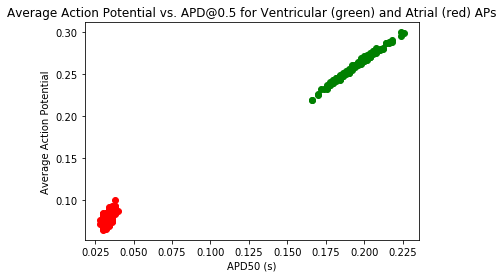

In [10]:
def ap_duration(ap_sample, percent):
    # find where AP hits max, must be at 1 since it was normalized
    max_index = (np.where(ap_sample == 1))[0]
    desired_index = max_index
    # increase index till we go only one past the desired APD@X
    while ap_sample[desired_index] > percent:
        desired_index += 1
    # return scaled to time
    return (desired_index / 500)
    
plt.figure()
atrial_aap = []
vent_aap = []
atrial_apd50 = []
vent_apd50 = []

# add AAP and APD50s for atrial data
for i in range(len(atrial_training_data)):
    atrial_aap.append(np.mean(og_atrial_data[i]))
    atrial_apd50.append(ap_duration(atrial_training_data[i], 0.5))

# add AAP and APD50s for ventricular data
for i in range(len(vent_training_data)):
    vent_aap.append(np.mean(og_vent_data[i]))
    vent_apd50.append(ap_duration(vent_training_data[i], 0.5))
    
# plot features of training samples  
plt.plot(atrial_apd50, atrial_aap, 'or')
plt.plot(vent_apd50, vent_aap, 'og')
plt.title('Average Action Potential vs. APD@0.5 for Ventricular (green) and Atrial (red) APs')
plt.ylabel('Average Action Potential')
plt.xlabel('APD50 (s)')

# Combining all training data
# Combining all APs
training_data = []
for i in range(len(atrial_training_data)):
    training_data.append(atrial_training_data[i])

for i in range(len(vent_training_data)):
    training_data.append(vent_training_data[i])


# Combining all AAPs and APD50s
all_aap = []
all_apd50 = []

for i in range(len(atrial_aap)):
    all_aap.append(atrial_aap[i])
    all_apd50.append(atrial_apd50[i])

for i in range(len(vent_aap)):
    all_aap.append(vent_aap[i])
    all_apd50.append(vent_apd50[i])

# Combine AAP and APD50 features in one matrix
all_apd50 = np.asarray(all_apd50)
all_aap = np.asarray(all_aap)
x_data = np.column_stack((all_apd50, all_aap))
# Find AAP and APD50s for test data, combine
test_apd50 = []
test_aap = []
for i in range(len(all_test_data)):
    test_aap.append(np.mean(og_test_data[i]))
    test_apd50.append(ap_duration(all_test_data[i], 0.5))
    
test_apd50 = np.asarray(test_apd50)
test_aap = np.asarray(test_aap)
test_features = np.column_stack((test_apd50, test_aap))


# create classification list and arrange based on index
# determined since atrial data was put in first
y_class = []
for i in range(len(x_data)):
    if i < len(atrial_training_data):
        y_class.append(int(-1))
    else:
        y_class.append(1)

test_class = []
for i in range(len(all_test_data)):
    if i < 900:
        test_class.append(int(-1))
    else:
        test_class.append(int(1))

Extracting PCA and Fourier features from your training data by using the first $d=10$ components in both cases. For the Fourier case I'm using the absolute value of the representation coefficients as your features.

Text(0.5,1,'First 10 Fourier Coefficients of First Training Data Sample')

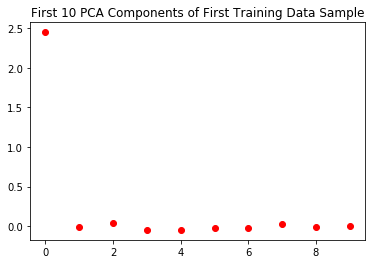

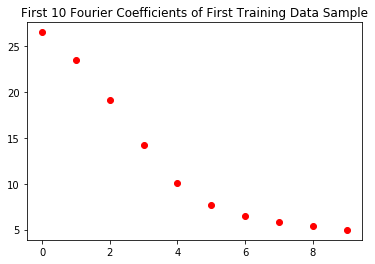

In [11]:
norm_training_data = training_data.copy()
# Subtract mean of training data since PCA requires zero-mean samples
for i in range(len(norm_training_data)):
    norm_training_data[i] = (norm_training_data[i] - np.mean(norm_training_data[i]))
    
norm_test_data = all_test_data.copy()
# Subtract mean from test data
for i in range(len(norm_test_data)):
    norm_test_data[i] = (norm_test_data[i] - np.mean(norm_test_data[i]))

# Get PCA components for training and test data
training_pca = PCA(n_components=10, copy=True)
training_components = training_pca.fit_transform(norm_training_data)
test_components = training_pca.fit_transform(norm_test_data)


plt.figure()
plt.plot(training_components[0], 'or')
plt.title('First 10 PCA Components of First Training Data Sample')

# Get first 10 fourier coefficients for training and test data
training_fft = (np.abs(np.fft.fft(training_data)))
test_fft = np.abs(np.fft.fft(all_test_data))
training_fft = training_fft[:, :10]
test_fft = test_fft[:, :10]


plt.figure()
plt.plot(training_fft[0], 'or')
plt.title('First 10 Fourier Coefficients of First Training Data Sample')


### Task 2. Classification
For this task, I'm using the Fourier training features of **Task 1** to validate my methods.

* _Nearest-neighbor classifier._
Implementing a $1$NN classifier using the Euclidean distance. Given the training dataset $\mathcal{D} = \big\{(\boldsymbol x_i,y_i)\big\}_{i=1}^{N}$,where $N$ is the number of training samples, $\boldsymbol x_i\in\mathbb{R}^D$ is a feature vector and $y_i\in\{-1,1\}$ its associated label, and a novel sample $\boldsymbol x$ find a label $\widehat y$ such that:
\begin{equation}
	\widehat y(\boldsymbol x) = y_{k^*},\quad k^* = \underset{i\in\{1,\ldots,N\}}{\arg\min}\, \lVert \boldsymbol x_i - \boldsymbol x \rVert_2.
\end{equation}


In [12]:

# Transposing the APD50 and AAP lists for ease of use

def classify(x, x_features, x_classification):
    best_index = 0
    error = np.linalg.norm(x_features[0] - x)
    
    for i in range(x_features.shape[0]):
        newerror = np.linalg.norm(x_features[i] - x)
        # find index with smallest euclidian distance
        if newerror < error:
            error = newerror
            best_index = i
    return x_classification[best_index]

# The first result should be 1 since it's from the ventricular portion of the data
print(classify(training_fft[150], training_fft, y_class))
# The first result should be -1 since it's from the atrial portion of the data
print(classify(training_fft[5], training_fft, y_class))

1
-1


* _Linear classifier._
 Implementing a linear binary classifier of the form:

   $$\widehat y = \operatorname{sign}\big(f_{\theta}(\boldsymbol x)\big),\quad f_{\theta}(\boldsymbol x) = \boldsymbol w^T\boldsymbol x + b,\quad \theta = \left[\begin{array}{c}\boldsymbol w\\b\end{array}\right],$$
  
 where $f_\theta(\boldsymbol x)$ is a _linear prediction function_ and $\theta = [\boldsymbol w^T, b]^T$ are the parameters of the linear predictor. In order to find the classifier's parameters $\theta$ I'm minimizing the following _regularized empirical risk_ I have selected:

   $$\min_{\boldsymbol w, b}\, \underbrace{\frac{1}{N} \sum_{i=1}^N L\big(f_\theta(\boldsymbol x_i),y_i\big) + \frac{\lambda}{2}\lVert \boldsymbol w\rVert^2}_{C(\boldsymbol w, b)}$$
    
 where the loss function $L(f, y) = \exp(-y f)$ is the exponential loss. 
 Implementing a _Gradient Descent_ (GD) scheme to solve the above optimization problem using:
 \begin{eqnarray}
 	\boldsymbol w^{(k+1)} &=& \boldsymbol w^{(k)} - \alpha^{(k+1)} \nabla_{\boldsymbol w} C,\\
 	b^{(k+1)} &=& b^{(k)} - \alpha^{(k+1)} \nabla_{b} C,
 \end{eqnarray}
 where $\alpha^{(k)}$ is the step-size for the gradient updates at iteration $k$. For the step-size I'm using an update rule as follows:
   $$\alpha^{(k)} = \alpha^{(0)} / \sqrt{k}.$$
 Setting $\lambda =1$  and playing with the value of the step-size $\alpha^{(0)}\in[10^{-1},10^{-3}]$ and the number of iterations in my GD algorithm to ensure a function decrease at every iteration and that it reaches the global minimizer. Plotting the evolution of the cost function as the number of iterations increases.

    * Note that the exponential loss function also penalizes correct decisions.



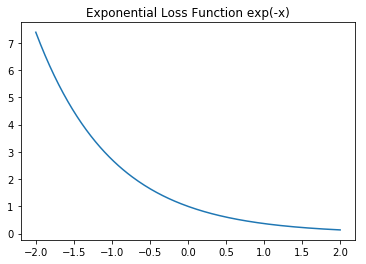

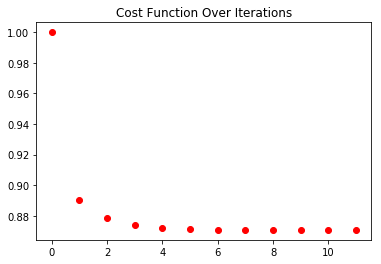

In [13]:
plt.figure()
domain = np.linspace(-2, 2, 200)
plt.plot(domain, np.exp(-1.0 * domain))
plt.title('Exponential Loss Function exp(-x)')

# Calculate the loss for one point
def loss(y, w, b, x):
    f = np.matmul(w, x) + b
    return np.exp(-1 * y * f)

# Calculate the cost function for one w and b given the data and labels
def calc_c(training_data, labels, w_mat, b):
    large_n = len(training_data)
    total_error = 0
    
    # Sum the loss for each point of training data
    for i in range(large_n):
        total_error += loss(labels[i], w_mat, b, training_data[i])
    # Divide by N and add regularizer  
    total_error /= large_n
    total_error += 0.5 * ((np.linalg.norm(w_mat)) ** 2)
    return total_error
    
# Initialize our w array with all wi values as 0
w = np.asarray([0.0] * 10)
# Had to make the step small or it would blow up
step = (10) ** -4
# Starting b as 0
b = 0

# Transpose w so we don't have to do it later
w = np.transpose(w)

# Get the first error
initial_err = calc_c(training_fft, y_class, w, b)
plt.figure()
plt.plot(0, initial_err, 'or')
plt.title('Cost Function Over Iterations')


###########################################
# Gradient of cost function:
#
# With respect to w: (1/N) * SUM(-1.0 * yi * xi * exp((w_t * xi + b)* -yi)) + w
#
# With respect to b: (1/N) * SUM(-1.0 * yi * exp((w_t * xi + b)* -yi))
###########################################

###########################################
# 12 iterations was found to be all that is necessary for this implementation
# Perform 12 iterations
for i in range(1, 12):
    # Change step size
    step = step / np.sqrt(i)
    # Keep copy of old w so we can use it for the b gradient
    w_old = w.copy()
    # Create the gradient array
    diff = np.asarray([0.0] * 10)
    # Add the sum of the gradient
    for j in range(len(training_fft)):
        diff += (-1.0 * y_class[j] * training_fft[j]) * loss(y_class[j], w_old, b, training_fft[j])
    diff /= len(training_fft)
    # Add gradient of regularizer
    diff += w_old
    w -= step * diff
    # Calculate new value of b
    diff = 0
    # Sum of gradient w.r.t. b
    for j in range(len(training_fft)):
        diff += (-1.0 * y_class[j]) * loss(y_class[j], w_old, b, training_fft[j])
    diff /= len(training_fft)
    b -= step * diff
    # Calculate new cost function and plot
    err = calc_c(training_fft, y_class, w, b)
    plt.plot(i, err, 'or')

# The exponential loss does penalize correct decisions, since e(-x) is positive for all x, and thus even
# correct decisions (i.e., y_hat == y) will add to the cost function

### Task 3. Validation on test set
For each of the considered features (i.e. hand-crafted APD and AAP, PCA, and Fourier) I repeat the following steps
using the test set defined in **Task 1**:

* _1NN classification._
 Classifing a test data set (already constructed) using a $1$NN classifier and displaying the classification accuracy over the test set.
 
* _Linear classification._
 Learning a linear classifier from the training data and using it to predict the labels of your test data. Finding appropriate values of the initial step-size $\alpha^{(0)}\in[10^{-1},10^{-3}]$ for the considered feature type and for the number of iterations of the gradient descent in order to ensure that it converges to the optimal value. I'm using $\lambda = 1$ for Fourier and PCA and $\lambda = 0.1$ for APD. Displaying the evolution of the objective value during optimization as well as the training and testing accuracies. Also plotting the prediction function $f_\theta(\boldsymbol x)$ over the test set.



Test data points to classify using AAP and APD50: 1800
Total data points successfully classified: 1800
Success rate of 1NN implementation using AAP and APD50: 100.0%
Test data points to classify using Fourier features: 1800
Total data points successfully classified: 1800
Success rate of 1NN implementation using Fourier Features: 100.0%
Test data points to classify using PCA components: 1800
Total data points successfully classified: 1800
Success rate of 1NN implementation using PCA components: 100.0%
Successful linear classifications with APD50 and AAP: 900
Success rate of linear classification with APD50 and AAP: 50.0%
Successful linear classifications with Fourier features: 1724
Success rate of linear classification with Fourier features: 95.77777777777777%
Successful linear classifications with PCA components: 1800
Success Rate of linear classification with PCA components: 100.0%


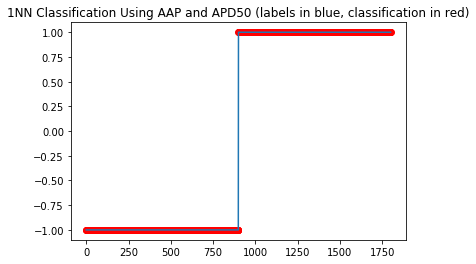

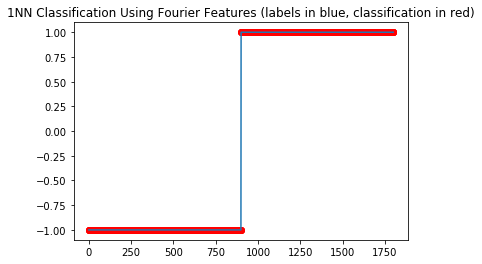

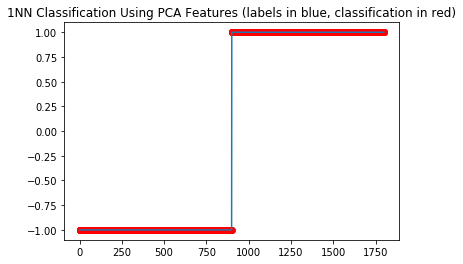

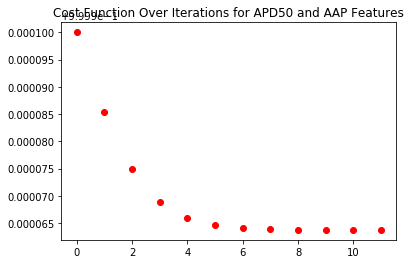

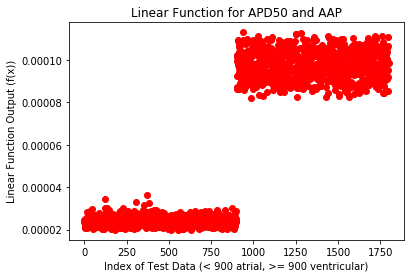

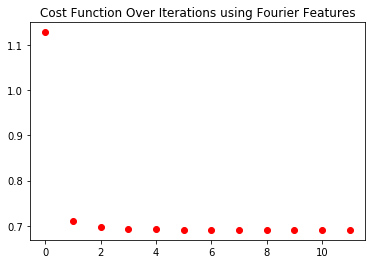

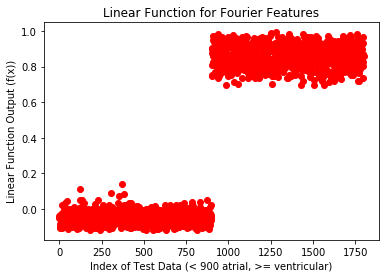

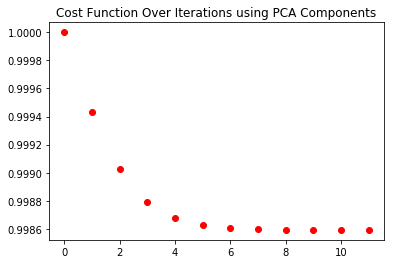

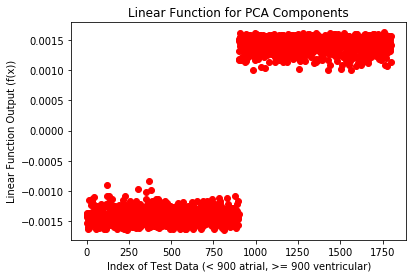

In [14]:
succ_classes = 0
num_test_points = test_features.shape[0]
print('Test data points to classify using AAP and APD50: ' + str(num_test_points))

# Add the number of correct classifications
# Plot classifications over data points
plt.figure()
for i in range(test_features.shape[0]):
    det_class = classify(test_features[i], x_data, y_class)
    plt.plot(i, det_class, 'or')
    if det_class == test_class[i]:
        succ_classes += 1
    
plt.plot(test_class)
plt.title('1NN Classification Using AAP and APD50 (labels in blue, classification in red)')
print('Total data points successfully classified: ' + str(succ_classes))
print('Success rate of 1NN implementation using AAP and APD50: ' + str(100 * float(succ_classes / num_test_points)) + '%')


succ_classes = 0
num_points = test_fft.shape[0]
print('Test data points to classify using Fourier features: ' + str(num_points))

# Add the number of correct classifications
# Plot classifications over data points
plt.figure()
for i in range(test_fft.shape[0]):
    det_class = classify(test_fft[i], training_fft, y_class)
    plt.plot(i, det_class, 'or')
    if det_class == test_class[i]:
        succ_classes += 1
    
plt.plot(test_class)
plt.title('1NN Classification Using Fourier Features (labels in blue, classification in red)')
print('Total data points successfully classified: ' + str(succ_classes))
print('Success rate of 1NN implementation using Fourier Features: ' + str(100 * float(succ_classes / num_points)) + '%')

# Add the number of correct classifications
# Plot classifications over data points
num_points = test_components.shape[0]
print('Test data points to classify using PCA components: ' + str(num_points))
succ_classes = 0
plt.figure()
for i in range(test_components.shape[0]):
    det_class = classify(test_components[i], training_components, y_class)
    plt.plot(i, det_class, 'or')
    if det_class == test_class[i]:
        succ_classes += 1
    
plt.plot(test_class)
plt.title('1NN Classification Using PCA Features (labels in blue, classification in red)')
print('Total data points successfully classified: ' + str(succ_classes))
print('Success rate of 1NN implementation using PCA components: ' + str(100 * float(succ_classes / num_points)) + '%')

##################################################################################################################
##################################################################################################################
##################################################################################################################
##################################################################################################################
# Linear classification validation
def sign(x):
    if x < 0:
        return -1
    else:
        return 1
# Initialize our w array with all wi values 0
w = np.asarray([0.0] * 2)
step = (10) ** -3
# Starting b as 0
b = 0.0

# Transpose w so we don't have to do it later
w = np.transpose(w)

# Get the first error
initial_err = calc_c(x_data, y_class, w, b)
plt.figure()
plt.plot(0, initial_err, 'or')
plt.title('Cost Function Over Iterations for APD50 and AAP Features')

# Go through iterations, improve w and b using gradient descent
for i in range(1, 12):
    step = step / np.sqrt(i)

    w_old = w
    
    diff = np.asarray([0.0] * 2)
    for j in range(len(training_fft)):
        diff += (-1.0 * y_class[j] * x_data[j]) * loss(y_class[j], w_old, b, x_data[j])
    diff /= len(x_data)
    diff += w_old
    w -= step * diff
        
    diff = 0
    for j in range(len(x_data)):
        diff += (-1.0 * y_class[j]) * loss(y_class[j], w_old, b, x_data[j])
    diff /= len(x_data)
    b -= step * diff
    # recalculate error and plot
    err = calc_c(x_data, y_class, w, b)
    plt.plot(i, err, 'or')

# Now w and b are our ideal linear parameters for the f function
plt.figure()
succ_classes = 0
plt.title('Linear Function for APD50 and AAP')
plt.xlabel('Index of Test Data (< 900 atrial, >= 900 ventricular)')
plt.ylabel('Linear Function Output (f(x))')
# Calcualte number of successful classes
for i in range(test_features.shape[0]):
    det_class = sign(np.matmul(w, test_features[i]) + b)
    plt.plot(i, np.matmul(w, test_features[i]) + b, 'or')
    if det_class == test_class[i]:
        succ_classes += 1

        
print('Successful linear classifications with APD50 and AAP: ' + str(succ_classes))
print('Success rate of linear classification with APD50 and AAP: ' + str(100 * float(succ_classes / test_features.shape[0])) + '%')




# Initialize our w array with all wi values 0
w = np.asarray([0.0] * 10)
step = (10) ** -4
# Starting b as -1
# This was found necessary to allow the classifier to learn correctly
# Possibly due to the small step, it cannot reach the optimized value without being close enough
b = -0.5

# Transpose w so we don't have to do it later
w = np.transpose(w)

# Get the first error
initial_err = calc_c(training_fft, y_class, w, b)
plt.figure()
plt.plot(0, initial_err, 'or')
plt.title('Cost Function Over Iterations using Fourier Features')

# Perform 12 iterations
for i in range(1, 12):
    # Change step size
    step = step / np.sqrt(i)
    # Keep copy of old w so we can use it for the b gradient
    w_old = w
    # Create the gradient array
    diff = np.asarray([0.0] * 10)
    # Add the sum of the gradient
    for j in range(len(training_fft)):
        diff += (-1.0 * y_class[j] * training_fft[j]) * loss(y_class[j], w_old, b, training_fft[j])
    diff /= len(training_fft)
    # Add gradient of regularizer
    diff += w_old
    w -= step * diff
    # Calculate new value of b
    diff = 0
    # Sum of gradient w.r.t. b
    for j in range(len(training_fft)):
        diff += (-1.0 * y_class[j]) * loss(y_class[j], w_old, b, training_fft[j])
    diff /= len(training_fft)
    b -= step * diff
    # Calculate new cost function and plot
    err = calc_c(training_fft, y_class, w, b)
    plt.plot(i, err, 'or')
    
plt.figure()
plt.title('Linear Function for Fourier Features')
plt.xlabel('Index of Test Data (< 900 atrial, >= ventricular)')
plt.ylabel('Linear Function Output (f(x))')
succ_classes = 0
# Calculate number of correct classifications
for i in range(test_fft.shape[0]):
    det_class = sign(np.matmul(w, test_fft[i]) + b)
    plt.plot(i, np.matmul(w, test_fft[i]) + b, 'or')
    if det_class == test_class[i]:
        succ_classes += 1
        
print('Successful linear classifications with Fourier features: ' + str(succ_classes))
print('Success rate of linear classification with Fourier features: ' + str(100 * float(succ_classes / test_fft.shape[0])) + '%')



# Initialize our w array with all wi values 0
w = np.asarray([0.0] * 10)
step = (10) ** -4
# Starting b as 0
b = 0

# Transpose w so we don't have to do it later
w = np.transpose(w)

# Get the first error
initial_err = calc_c(training_components, y_class, w, b)
plt.figure()
plt.plot(0, initial_err, 'or')
plt.title('Cost Function Over Iterations using PCA Components')

# Perform x number of iterations
for i in range(1, 12):
    # Change step size
    step = step / np.sqrt(i)
    # Keep copy of old w so we can use it for the b gradient
    w_old = w
    # Create the gradient array
    diff = np.asarray([0.0] * 10)
    # Add the sum of the gradient
    for j in range(len(training_components)):
        diff += (-1.0 * y_class[j] * training_components[j]) * loss(y_class[j], w_old, b, training_components[j])
    diff /= len(training_components)
    # Add gradient of regularizer
    diff += w_old
    w -= step * diff
    # Calculate new value of b
    diff = 0
    # Sum of gradient w.r.t. b
    for j in range(len(training_components)):
        diff += (-1.0 * y_class[j]) * loss(y_class[j], w_old, b, training_components[j])
    diff /= len(training_components)
    b -= step * diff
    # Calculate new cost function and plot
    err = calc_c(training_components, y_class, w, b)
    plt.plot(i, err, 'or')
    
plt.figure()
plt.title('Linear Function for PCA Components')
plt.xlabel('Index of Test Data (< 900 atrial, >= 900 ventricular)')
plt.ylabel('Linear Function Output (f(x))')
succ_classes = 0
# Calculate number of successful classes
for i in range(test_components.shape[0]):
    det_class = sign(np.matmul(w, test_components[i]) + b)
    plt.plot(i, np.matmul(w, test_components[i]) + b, 'or')
    if det_class == test_class[i]:
        succ_classes += 1
        
print('Successful linear classifications with PCA components: ' + str(succ_classes))
print('Success Rate of linear classification with PCA components: ' + str(100 * float(succ_classes / test_components.shape[0])) + '%')